# Integration of histone modification - chromatin state analysis

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from SEMITONES.support_funcs import sig_dictionary
from SEMITONES.enrichment_scoring import sig_interval
import scanpy as sc
import re
from sklearn.preprocessing import binarize
import anndata as ad
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_kernels
from SEMITONES.support_funcs import pairwise_similarities
from SEMITONES.cell_selection import from_knn_dist
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
import itertools

In [3]:
meta = pd.read_csv('../../raw/roadmap/Roadmap.metadata.qc.jul2013 - Consolidated_EpigenomeIDs_summary_Table.csv')

In [4]:
adata_atac = sc.read_h5ad('../../processed/10X_multiome/pbmc_atac.h5ad')
adata_atac.layers['b_atac'] = binarize(adata_atac.X)

In [5]:
adata_rna = sc.read_h5ad('../../processed/10X_multiome/pbmc_rna.h5ad')
# cpm normalization of RNA
norm_rna = sc.pp.normalize_total(adata_rna, target_sum=1e6, copy=True)
sc.pp.log1p(norm_rna)
adata_rna.layers['lognorm_rna'] = norm_rna.X

In [6]:
tenX_es = pd.read_hdf('../../processed/10X_multiome/ATAC_escore.h5','escores')
tenX_ps = pd.read_hdf('../../processed/10X_multiome/ATAC_pscore.h5','pscores')

tenX_interval = sig_interval(tenX_ps, n_sds=10)
tenX_sigdict_acc = sig_dictionary(tenX_es, tenX_interval, sign='positive')
tenX_sigdict_inacc = sig_dictionary(tenX_es, tenX_interval, sign='negative')
tenX_sigdict = sig_dictionary(tenX_es, tenX_interval)

In [13]:
# Homer annotation
tenX_ann = pd.read_csv('../../processed/10X_multiome/ATAC_ann.txt', sep='\t', index_col=0)
tenX_ann.sort_index(inplace=True)
tenX_ann.reset_index(drop=True, inplace=True)

In [14]:
wnn_umap25= np.genfromtxt('../../processed/10X_multiome/wnn_umap25.csv', delimiter=',')

# find reference cells
g=0.68

S = pairwise_kernels(wnn_umap25, metric='rbf',gamma=g)
median = np.median(S, axis=0)
start = int(np.argmin(median))

dd_rcells = from_knn_dist(X=wnn_umap25,
                         n_ret=100,
                         start=start,
                         metric='rbf',
                         metric_params={"gamma": g})

S_to_r = pairwise_similarities(wnn_umap25,query=dd_rcells,metric='rbf',metric_params={"gamma": g})
S_df = pd.DataFrame(data=S_to_r, columns=dd_rcells)

In [15]:
# id to cell type dictionary
id_ct={'E029':['CD14 Mono','CD16 Mono'],
       'E032':['B intermediate','B memory','Plasmablast','B naive'],
       'E034':['CD4 Naive','CD4 TCM','CD8 Naive','Treg','CD8 TCM','CD4 TEM','MAIT','CD8 TEM','gdT','CD4 CTL','dnT','CD4 Proliferating'],
       'E035':['HSPC'],
       'E037':['CD4 TCM','CD4 TEM'],
       'E038':['CD4 Naive'],
       'E039':['CD4 Naive'],
       'E040':['CD4 TCM','CD4 TEM'],
       'E043':['CD4 Naive','CD4 TCM','CD4 TEM','CD4 Proliferating'],
       'E044':['Treg'],
       'E045':['CD4 TEM','CD8 TEM'],
       'E046':['NK','NK Proliferating','NK_CD56bright'],
       'E047':['CD8 Naive'],
       'E048':['CD8 TCM','CD8 TEM'],
       'E124':['CD14 Mono']
      }

In [16]:
# id to epigenomic name dictionary
id_ename={}
for id in id_ct:
    name = meta.loc[meta['Epigenome ID (EID)']==id, 'Standardized Epigenome name'].to_list()[0].replace(u'\xa0',u' ')
    id_ename[id]=name

In [17]:
# id to simplified name dictionary
id_sname={
    'E029': 'Monocytes',
 'E032': 'B cells',
 'E034': 'T cells',
 'E035': 'HSC',
 'E037': 'T helper memory cells 2',
 'E038': 'T helper naive cells 1',
 'E039': 'T helper naive cells 2',
 'E040': 'T helper memory cells 1',
 'E043': 'T helper cells',
 'E044': 'Treg',
 'E045': 'T cells effector memory',
 'E046': 'NK',
 'E047': 'T CD8+ naive cells',
 'E048': 'T CD8+ memory cells',
 'E124': 'Monocytes-CD14+'}

In [18]:
# reference cell to cell type dictionary
rcell_ct = {}
for rcell in tenX_sigdict_acc.keys():
    rcell_ct[rcell] = adata_atac.obs['predicted.id'][rcell]

In [19]:
# dataframes of chromatin ranges from all regions and promoters
atac_bed = tenX_ann.loc[:, ['Chr','Start','End','Gene Name','GC%']]
atac_bed['Start'] = atac_bed['Start']-1

atac_prom_bed = tenX_ann.loc[tenX_ann['Annotation'].str.contains('promoter').fillna(False), ['Chr','Start','End','Gene Name','GC%']]
atac_prom_bed['Start'] = atac_prom_bed['Start']-1

In [20]:
prom_set = set(np.where(tenX_ann['Annotation'].str.contains('promoter').fillna(False))[0])

In [26]:
# collect 5 histone methylation data of a cell type
def get_prom_info(id, prom=True):
    # the directory that stores bedtools output files
    dir = '../../processed/roadmap/'
    
    # use five essential marks
    mod_used = ['H3K4me3','H3K4me1','H3K36me3','H3K9me3','H3K27me3']
    fnl = [id+'-'+x+'.bed' for x in mod_used]

    all_df = atac_bed.set_index(['Chr','Start','End'])
    prom_info = atac_prom_bed.set_index(['Chr','Start','End'])
    append_data = []
    for fn in fnl:
        infol=re.split(r'/|-|_|.bed',fn)
        bed_closest = pd.read_csv(dir+fn,header=None,sep='\t')
        bed_closest[19] = 1
        
        # column 12 represents signalValue of ChIP-seq according to http://genome.ucsc.edu/FAQ/FAQformat.html#format14
        bed_closest.rename(columns={12:infol[1], 15:'Chr', 16:'Start', 17:'End', 18:'distance', 19:'count'}, inplace=True)
        bed_closest = bed_closest.loc[bed_closest['distance']>=0,:]

        # select histone marks closer than 1000
        bed_closest = bed_closest.loc[bed_closest['distance']<1000,:]

        grp = bed_closest.groupby(['Chr','Start','End'])
        bed_closest = grp[[infol[1],'distance']].mean()
        bed_closest['count'] = grp['count'].sum()

        append_data.append(bed_closest[infol[1]])

    # concat with atac regions
    data = pd.concat(append_data, axis=1)
    
    if prom:
        prom_info.dropna(inplace=True)
        prom_info = pd.concat([prom_info, data], axis = 1)
        prom_info = prom_info.fillna(0)
        prom_info = prom_info.loc[prom_info['GC%'] != 0,:]
        return prom_info
    
    else:
        all_df.dropna(inplace=True)
        all_df = pd.concat([all_df, data], axis = 1)
        all_df = all_df.fillna(0)
        # some mod regions do not have gene names
        all_df = all_df.loc[all_df['GC%'] != 0,:]
        return all_df

In [27]:
# determine #clusters, because this step is slow, create id_nclus dictionary
id_nclus = {}
for id in id_ct.keys():
    
    prom_info = get_prom_info(id)
    
    prom_df = np.log2(prom_info.iloc[:,2:]+1)

    prom_df = (prom_df-prom_df.min(axis=0))/(prom_df.max(axis=0)-prom_df.min(axis=0))
    
    # determine how many clusters to use
    n_l = np.arange(10,20)
    mean_score = []
    for n in n_l:
        kmeans = KMeans(n_clusters=n, random_state=12).fit(prom_df)
        s = silhouette_score(prom_df, kmeans.labels_)
        mean_score.append(s)
    
    n_clus = n_l[mean_score.index(np.max(mean_score))]
    id_nclus[id] = n_clus

In [28]:
# summarize accessibility, gex, and GC content grouped by the clusters
def acc_gex_gc_df(prom_df, cell_id, kmeans, clus_state_dict=None):
    if clus_state_dict==None:
        labels = kmeans.labels_
    else:
        labels = np.array([clus_state_dict[x] for x in kmeans.labels_])
        
    
    all_mean_l = np.mean(adata_atac.layers['b_atac'][cell_id,:].todense(), axis=0).tolist()[0]

    access = pd.Series(all_mean_l, index = atac_bed.loc[:,['Chr','Start','End']], name='accessibility')

    sum_df = prom_df.copy()
    sum_df['group'] = labels
    sum_df = pd.concat([sum_df, access], axis=1, join='inner')
    
    all_gene_expr = np.mean(adata_rna.layers['lognorm_rna'][cell_id,:].todense(), axis=0).tolist()[0]

    gexpr = pd.DataFrame({'gene expression':all_gene_expr, 'Gene Name':adata_rna.var['features']})
    gexpr = pd.merge(atac_prom_bed, gexpr, on='Gene Name', how='inner').set_index(['Chr','Start','End'])

    sum_g_df = prom_df.copy()
    sum_g_df['group'] = labels
    sum_g_df = pd.concat([sum_g_df, gexpr], axis=1, join='inner')
    
    gc_df = prom_df.copy()
    gc_df['group'] = labels
    gc_df = pd.concat([gc_df, atac_bed.set_index(['Chr','Start','End'])], axis=1, join='inner')
    
    return sum_df, sum_g_df, gc_df

In [29]:
# collect p-values of testing the values in each cluster against the background median or mean (one sample test)
def make_p_sum_df(sum_df, sum_g_df, gc_df, n_clus, all_prom_atac_m, all_prom_gex_m, all_gc):
    p_sum_df = pd.DataFrame(index=np.arange(0,n_clus))

    all_med = np.median(all_prom_atac_m)
    plist = []
    clist = []
    for grp in np.sort(sum_df['group'].unique()): 
        series = sum_df.loc[sum_df['group']==grp, 'accessibility']
        d = (series - all_med).to_list()
        w, p = stats.wilcoxon(d)
        plist.append(p)

        # -1: log(pval) will be negative, makes upregulation positive
        clist.append(-1) if (series.median()-all_med)>=0 else clist.append(1)

    p_sum_df['accessibility'] = np.log10(multipletests(plist, method='fdr_bh')[1]) * clist


    all_med = np.median(all_prom_gex_m)
    plist = []
    clist = []
    for grp in np.sort(sum_g_df['group'].unique()):
        series = sum_g_df.loc[sum_g_df['group']==grp, 'gene expression']
        d = (series - all_med).to_list()
        w, p = stats.wilcoxon(d)
        plist.append(p)

        clist.append(-1) if (series.median()-all_med)>=0 else clist.append(1)

    p_sum_df['gene expression'] = np.log10(multipletests(plist, method='fdr_bh')[1]) * clist


    all_mu = np.mean(all_gc)
    plist = []
    clist = []
    for grp in np.sort(gc_df['group'].unique()):
        series = gc_df.loc[gc_df['group']==grp, 'GC%']
        s, p = stats.ttest_1samp(series, all_mu)
        plist.append(p)

        clist.append(-1) if (series.mean()-all_mu)>=0 else clist.append(1)

    p_sum_df['GC%'] = np.log10(multipletests(plist, method='fdr_bh')[1]) * clist
    
    return p_sum_df

In [30]:
# define states by their histone modification patterns
acc_p_s = []
gex_p_s = []
gc_p_s = []
    
for id in id_ct:
    # read and process the file
    prom_info = get_prom_info(id)
    
    # data transformation
    prom_df = np.log2(prom_info.iloc[:,2:]+1)
    prom_df = (prom_df-prom_df.min(axis=0))/(prom_df.max(axis=0)-prom_df.min(axis=0))
    
    # kmeans clustering, n_clus is pre-determined above in id_nclus dict
    n_clus = id_nclus[id]
    kmeans = KMeans(n_clusters=n_clus, random_state=12).fit(prom_df)
    
    heatmap_df = prom_df.copy()
    heatmap_df['cluster'] = kmeans.labels_
    heatmap_df = heatmap_df.groupby(['cluster']).mean()
    
    # collect rcells in the cell-type
    rcells = []
    for ct in id_ct[id]:
        for rcell in tenX_sigdict_acc.keys():

            if rcell_ct[rcell] == ct:
                rcells.append(rcell)

            else:
                continue
    
    # collect cell_ids for mean accessibility and gene expression of all promoters
    cell_id =[]
    for rcell in rcells:
        # select k neareast neighbors
        k=20
        cell_id.extend(S_df[S_df[rcell].rank(ascending=False)<(k+2)].index.to_list())
    cell_id = list(set(cell_id))
    
    # summarize accessibility, gex, and GC content grouped by the clusters
    sum_df, sum_g_df, gc_df = acc_gex_gc_df(prom_df, cell_id, kmeans)
    
    # collect p-values of testing the values in each cluster against the background median or mean (one sample test)
    all_prom_atac_m = np.mean(adata_atac.layers['b_atac'][cell_id,:][:,list(prom_set)].todense(), axis=0).tolist()[0]

    all_gene_expr = np.mean(adata_rna.layers['lognorm_rna'][cell_id,:].todense(), axis=0).tolist()[0]

    gexpr = pd.DataFrame({'gene expression':all_gene_expr, 'Gene Name':adata_rna.var['features']})
    all_prom_gex_m = pd.merge(atac_prom_bed, gexpr, on='Gene Name', how='inner')['gene expression']

    all_gc = tenX_ann.iloc[list(prom_set),-1]
    
    p_sum_df = make_p_sum_df(sum_df, sum_g_df, gc_df, n_clus, all_prom_atac_m, all_prom_gex_m, all_gc)
       
    mod_enrich_df = heatmap_df.copy()
    # use signalValue 0.5 as the threshold to define an enriched or not enriched histone mark
    mod_enrich_df[mod_enrich_df>=0.5]=1
    mod_enrich_df[mod_enrich_df<0.5]=0
    
    
    concat_df = pd.concat([mod_enrich_df, p_sum_df],axis=1)
    concat_df = concat_df.groupby(['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']).mean()
    s = concat_df['accessibility']
    s.name = id_sname[id]
    acc_p_s.append(s)
    
    s = concat_df['gene expression']
    s.name = id_sname[id]
    gex_p_s.append(s)
    
    s = concat_df['GC%']
    s.name = id_sname[id]
    gc_p_s.append(s)

acc_df = pd.concat(acc_p_s, axis=1).fillna(0)
gex_df = pd.concat(gex_p_s, axis=1).fillna(0)
gc_df = pd.concat(gc_p_s, axis=1).fillna(0)

In [31]:
# set the maximum p-value to 10 for visualization
acc_df[acc_df>10]=10
acc_df[acc_df<-10]=-10
gex_df[gex_df>10]=10
gex_df[gex_df<-10]=-10
gc_df[gc_df>10]=10
gc_df[gc_df<-10]=-10

/tmp/ipykernel_36735/94337760.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar_labels)
/tmp/ipykernel_36735/94337760.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar_labels)
/tmp/ipykernel_36735/94337760.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(cbar_labels)


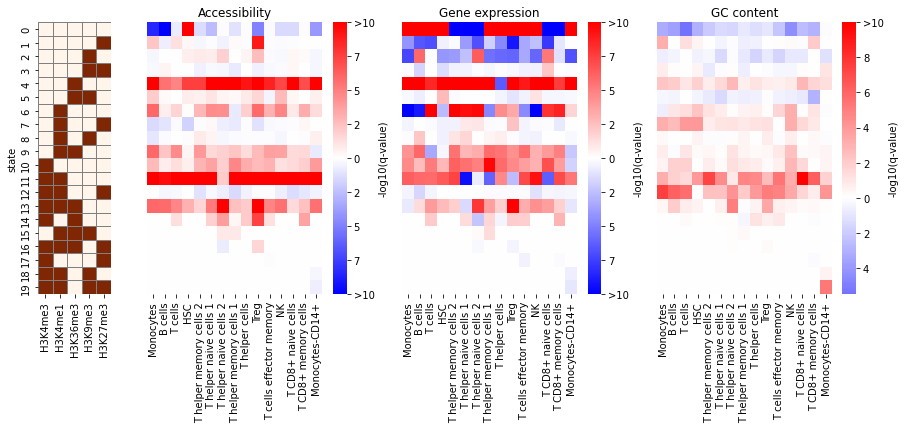

In [32]:
# visualize the test results of each state
fig, axs = plt.subplots(1,4, figsize=(15,5), gridspec_kw={'width_ratios': [1.5,4.5,4.5,4.5]})

y_hm = acc_df.reset_index().loc[:,['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']]
sns.heatmap(y_hm, ax=axs[0],
           cmap='Oranges', cbar=False,
            linecolor='grey', linewidths=.5)
axs[0].set(ylabel='state')

sns.heatmap(acc_df, ax=axs[1],
           cmap='bwr', center=0, cbar_kws={'label': '-log10(q-value)'},
            yticklabels=False)
cbar = axs[1].collections[0].colorbar
#cbar.set_ticks(cbar.get_ticks())
cbar_labels = [str(int(x)) for x in abs(cbar.get_ticks())]
cbar_labels[0] = '>10'
cbar_labels[-1] = '>10'
cbar.set_ticklabels(cbar_labels)
axs[1].set_ylabel('')
axs[1].set_title('Accessibility')

sns.heatmap(gex_df, ax=axs[2],
           cmap='bwr', center=0, cbar_kws={'label': '-log10(q-value)'},
            yticklabels=False)
cbar = axs[2].collections[0].colorbar
#cbar.set_ticks(cbar.get_ticks())
cbar_labels = [str(int(x)) for x in abs(cbar.get_ticks())]
cbar_labels[0] = '>10'
cbar_labels[-1] = '>10'
cbar.set_ticklabels(cbar_labels)
axs[2].set_ylabel('')
axs[2].set_title('Gene expression')

sns.heatmap(gc_df, ax=axs[3],
           cmap='bwr', center=0, cbar_kws={'label': '-log10(q-value)'},
            yticklabels=False)
cbar = axs[3].collections[0].colorbar
#cbar.set_ticks(cbar.get_ticks())
cbar_labels = [str(int(x)) for x in abs(cbar.get_ticks())]
cbar_labels[-1] = '>10'
cbar.set_ticklabels(cbar_labels)
axs[3].set_ylabel('')
axs[3].set_title('GC content')
fig.savefig('../../figures/roadmap/cluster_pval.png', bbox_inches = "tight", dpi=300)

plt.show()

In [35]:
state_df = acc_df.reset_index().loc[:,['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3']]
state_df.index.name='state'

In [37]:
def show_hm_dist(id):
    # read and process the file
    prom_info = get_prom_info(id)

    # filter the data
    prom_df = np.log2(prom_info.iloc[:,2:]+1)

    prom_df = (prom_df-prom_df.min(axis=0))/(prom_df.max(axis=0)-prom_df.min(axis=0))

    # kmeans clustering, n_clus is pre-determined above in id_nclus dict
    n_clus = id_nclus[id]
    kmeans = KMeans(n_clusters=n_clus, random_state=12).fit(prom_df)    

    # collect rcells in the cell-type
    rcells = []
    for ct in id_ct[id]:
        for rcell in tenX_sigdict_acc.keys():

            if rcell_ct[rcell] == ct:
                rcells.append(rcell)

            else:
                continue

    # collect cell_ids for mean accessibility and gene expression of all promoters
    cell_id =[]
    for rcell in rcells:
        # select k neareast neighbors
        k=20
        cell_id.extend(S_df[S_df[rcell].rank(ascending=False)<(k+2)].index.to_list())
    cell_id = list(set(cell_id))

    # create clus_state_dict based on the heatmap
    heatmap_df = prom_df.copy()
    heatmap_df['cluster'] = kmeans.labels_
    heatmap_df = heatmap_df.groupby(['cluster']).mean()

    # find enrichment patterns
    mod_enrich_df = heatmap_df.copy()
    mod_enrich_df[mod_enrich_df>=0.5]=1
    mod_enrich_df[mod_enrich_df<0.5]=0

    # clus_state_series: index is cluster, values are states
    clus_state_series = pd.merge(mod_enrich_df,state_df.reset_index(),on=['H3K4me3', 'H3K4me1', 'H3K36me3', 'H3K9me3', 'H3K27me3'],how='left')['state']
    clus_state_dict=dict(clus_state_series)


    # plots
    fig, axs = plt.subplots(1,2,figsize=(12,5), gridspec_kw={'width_ratios': [1,6]})
    fig.suptitle(id_sname[id])

    labels = np.array([clus_state_dict[x] for x in kmeans.labels_])
    name = 'state'
    
    # heatmap
    heatmap_df = prom_df.copy()
    heatmap_df['group'] = labels
    heatmap_df = heatmap_df.groupby(['group']).mean()

    sns.heatmap(heatmap_df, ax=axs[0],
                cmap='Oranges',cbar_kws={'label': 'mean signal value'},
                     linecolor='grey', linewidths=.5)
    axs[0].set(ylabel=name)


    # selectively accessible/inaccessible
    df = prom_df.copy()
    df['group'] = np.array([clus_state_dict[x] for x in kmeans.labels_])

    acc_feature_id = []
    inacc_feature_id = []
    for rcell in rcells:
        acc_feature_id.extend(tenX_sigdict_acc[rcell])
        inacc_feature_id.extend(tenX_sigdict_inacc[rcell])
    acc_feature_id = list(set(acc_feature_id))
    inacc_feature_id = list(set(inacc_feature_id))

    acc_df = atac_bed.set_index(['Chr','Start','End']).iloc[acc_feature_id,:]
    acc_sum = pd.concat([df,acc_df],axis=1,join='inner')['group'].value_counts()

    inacc_df = atac_bed.set_index(['Chr','Start','End']).iloc[inacc_feature_id,:]
    inacc_sum = pd.concat([df,inacc_df],axis=1,join='inner')['group'].value_counts()


    acc_sum.name = 'accessible'
    acc_nsum = acc_sum*100/acc_sum.sum()

    inacc_sum.name = 'inaccessible'
    inacc_nsum = inacc_sum*100/inacc_sum.sum()

    # fisher exact test
    bg = df['group'].value_counts(normalize=True).sort_index()*100
    bg.name='expected'
    test_df = pd.concat([bg, acc_nsum, inacc_nsum], axis=1, join='outer').fillna(0)

    bg_n = df['group'].value_counts().sort_index()
    bg_n.name='expected'
    number_df = pd.concat([bg_n, acc_sum, inacc_sum], axis=1, join='outer').fillna(0)

    cnumber_df = number_df.copy()

    unmod_num_df = cnumber_df.div(test_df/100) - cnumber_df
    unmod_num_df.fillna(0, inplace=True)


    cnumber_df['non sa'] = cnumber_df['expected'] - cnumber_df['accessible']
    unmod_num_df['non sa'] = unmod_num_df['expected'] - unmod_num_df['accessible']
    
    # p-values for selectively accessible promoters
    sa_ps = []
    for state in cnumber_df.index:
        conti = pd.concat([cnumber_df.loc[state,['non sa','accessible']], unmod_num_df.loc[state,['non sa','accessible']]],axis=1)
        r, p = stats.fisher_exact(conti)
        sa_ps.append(p)


    cnumber_df['non si'] = cnumber_df['expected'] - cnumber_df['inaccessible']
    unmod_num_df['non si'] = unmod_num_df['expected'] - unmod_num_df['inaccessible']
    
    # p-values for selectively inaccessible promoters
    si_ps = []
    for state in cnumber_df.index:
        conti = pd.concat([cnumber_df.loc[state,['non si','inaccessible']], unmod_num_df.loc[state,['non si','inaccessible']]],axis=1)
        r, p = stats.fisher_exact(conti)
        si_ps.append(p)

    fisher_res = pd.DataFrame({'sel. acc.':sa_ps,'sel. inacc.':si_ps}, index=cnumber_df.index)
    
    # create the list of p-value strings for annotations on the plot
    strnum_df = number_df.copy()

    values = []
    for sname in number_df.index:
        if (fisher_res['sel. acc.']<0.001)[sname]:
            values.append(str(int(number_df['accessible'][sname]))+'*')
        else:
            values.append(str(int(number_df['accessible'][sname])))
    strnum_df['strsel. acc.']=values

    values = []
    for sname in number_df.index:
        if (fisher_res['sel. inacc.']<0.001)[sname]:
            values.append(str(int(number_df['inaccessible'][sname]))+'*')
        else:
            values.append(str(int(number_df['inaccessible'][sname])))
    strnum_df['strsel. inacc.']=values
    
    # bar plot
    width=0.25
    x=np.arange(test_df.shape[0])

    g1 = axs[1].bar(x-width,test_df['expected'], width, label='expected',color='purple')
    g2 = axs[1].bar(x,test_df['accessible'], width, label='sel. accessible', color='orange')
    g3 = axs[1].bar(x+width,test_df['inaccessible'], width, label='sel. inaccessible', color='green')

    axs[1].set_xticks(x, test_df.index)
    axs[1].set(xlabel='state',ylabel='percentage')
    axs[1].legend()

    axs[1].bar_label(g1, labels=[int(x) for x in strnum_df['expected']], padding=5, rotation=90)
    axs[1].bar_label(g2, labels=[x for x in strnum_df['strsel. acc.']], padding=5, rotation=90)
    axs[1].bar_label(g3, labels=[x for x in strnum_df['strsel. inacc.']], padding=5, rotation=90)

    axs[1].spines.right.set_visible(False)
    axs[1].spines.top.set_visible(False)

    fig.tight_layout()
    plt.show()

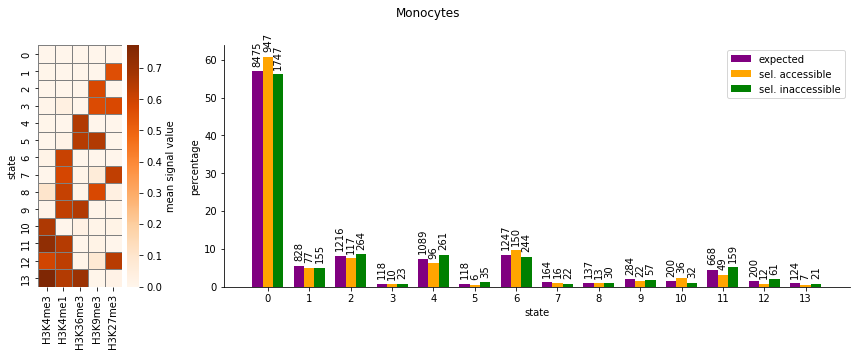

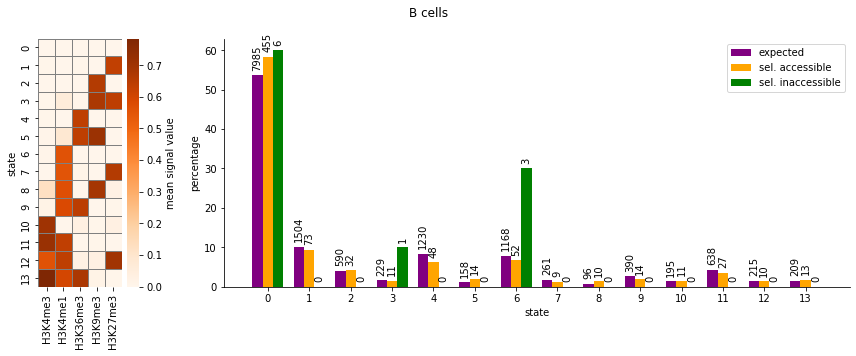

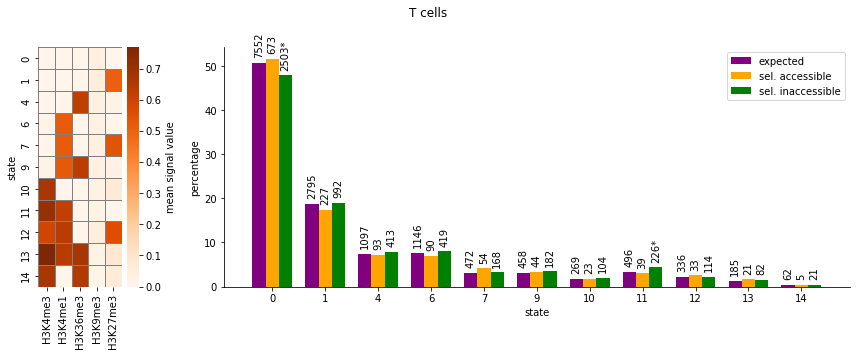

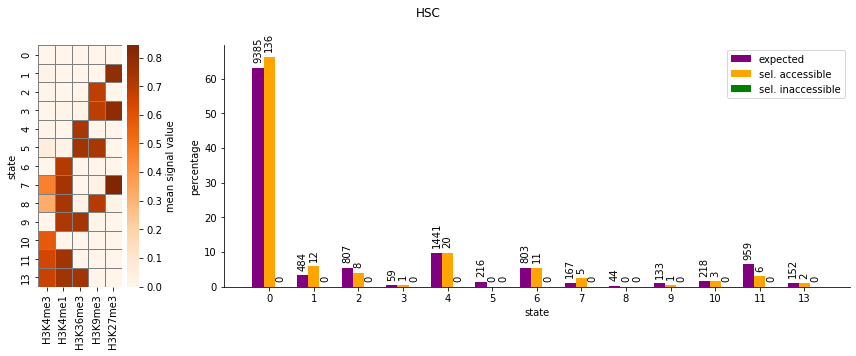

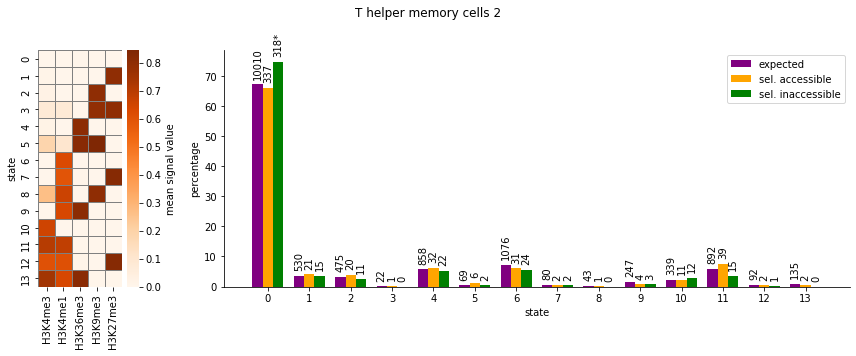

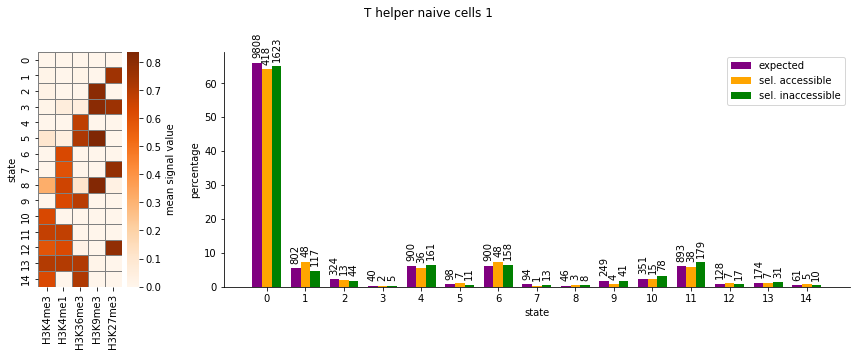

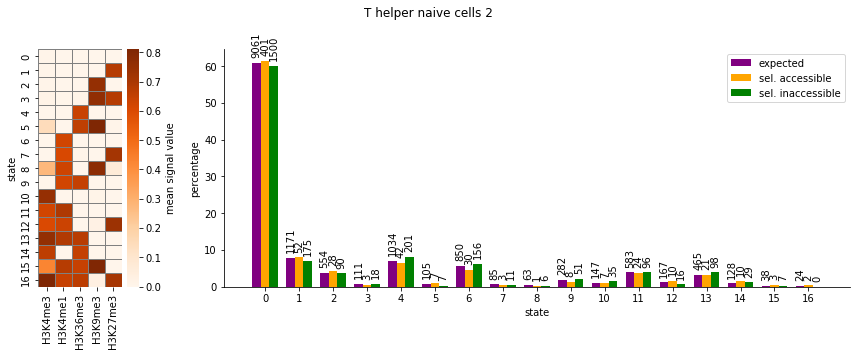

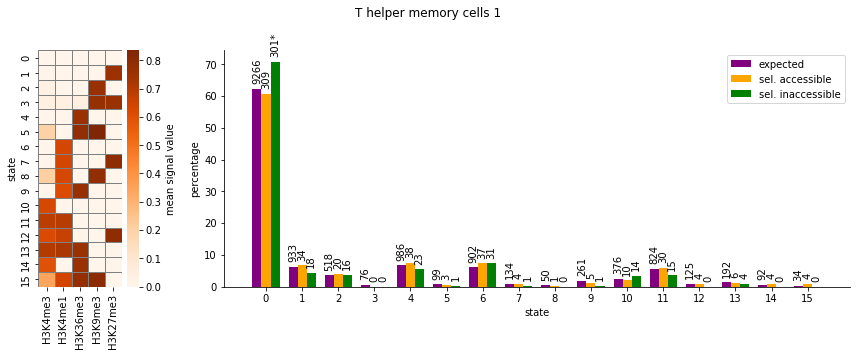

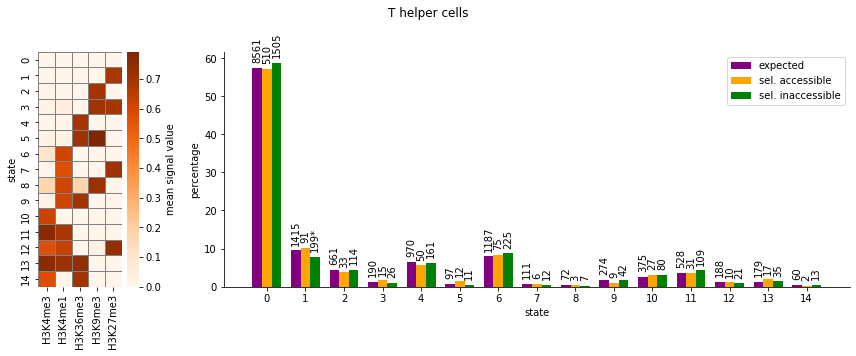

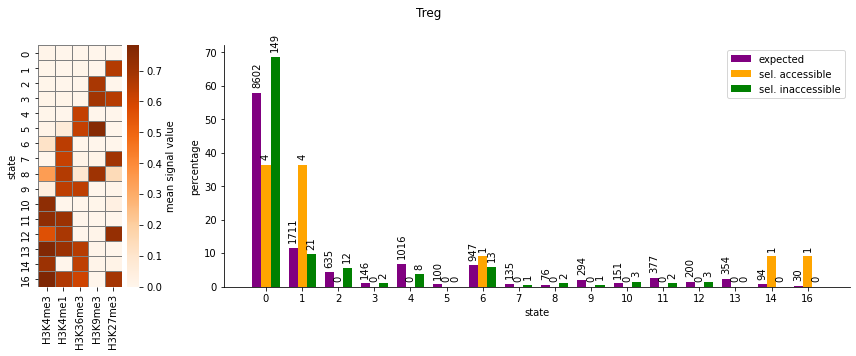

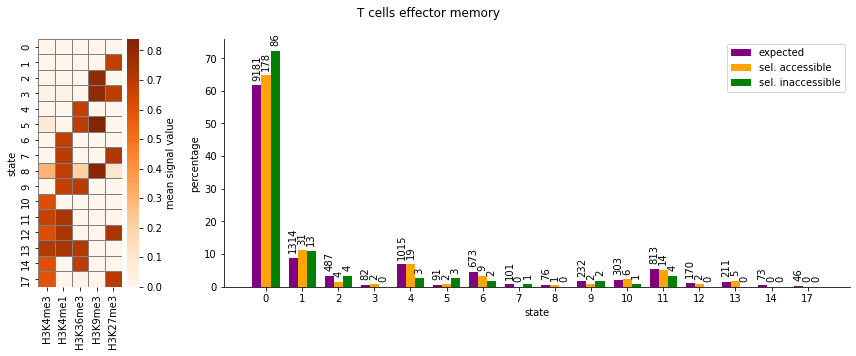

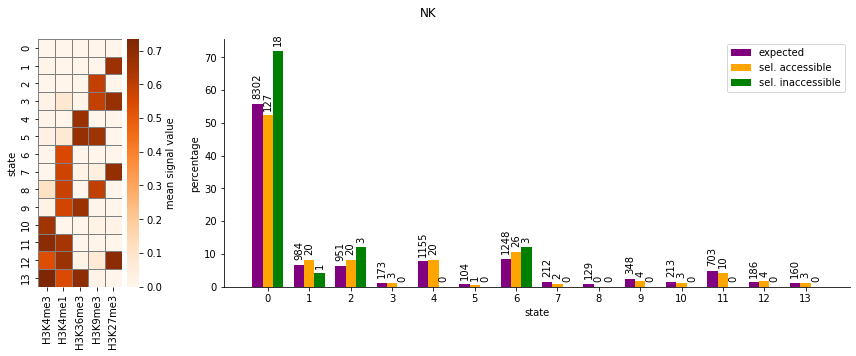

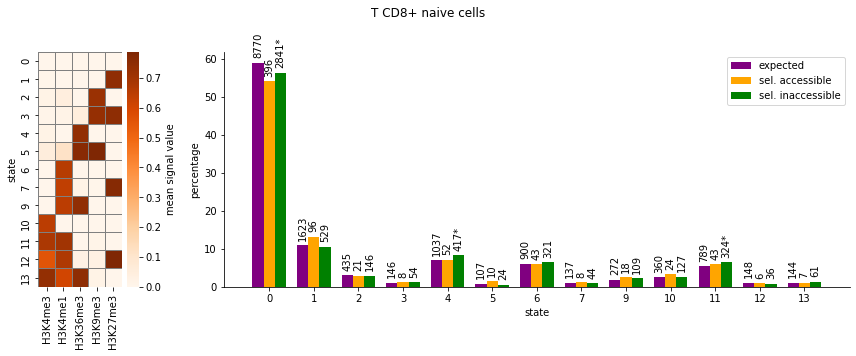

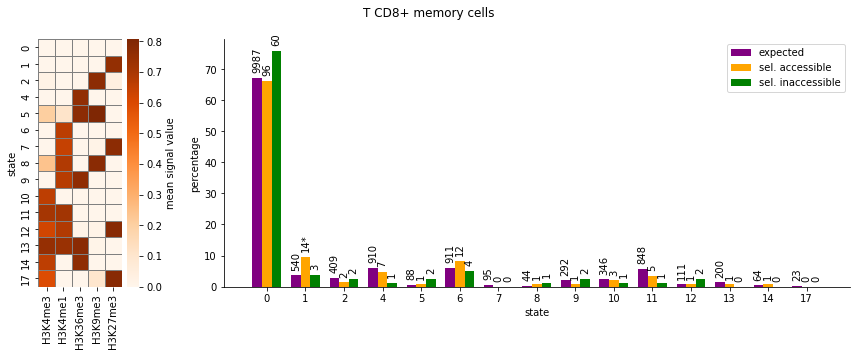

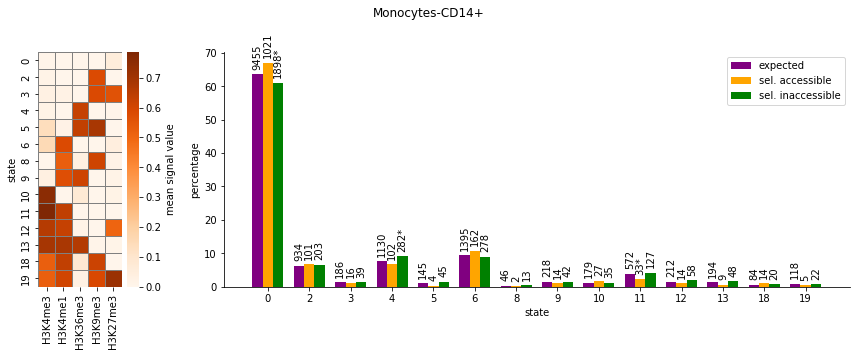

In [38]:
for id in id_ct:
    show_hm_dist(id)